In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
# plt.style.use('seaborn-white')

In [4]:
df = pd.read_excel('Data/Default.xlsx', index_col = 0)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

In [5]:
## We are interested in making model with Balance and predict default2
X = df.balance.values.reshape(-1, 1)
y = df.default2.values.reshape(-1, 1)

X_range = np.linspace(X.min(), X.max(), 10000).reshape(-1, 1)
## sklearn log reg model
model = skl_lm.LogisticRegression()
model.fit(X, y)
prediction = model.predict(X)
prediction_prob = model.predict_proba(X_range)[:,1]

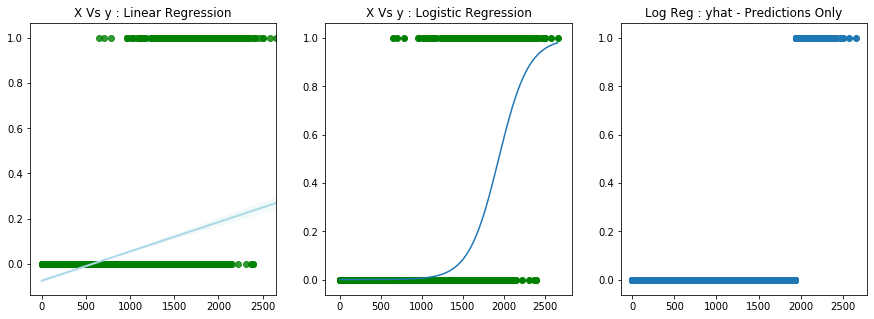

In [6]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.title("X Vs y : Linear Regression")
sns.regplot(X, y, scatter_kws={'color':'green'}, line_kws={'color':'lightblue', 'lw':2})
plt.subplot(132)
plt.plot(X_range, prediction_prob)
plt.scatter(X, y,color =  'g')
plt.title("X Vs y : Logistic Regression")
plt.subplot(133)
plt.title("Log Reg : yhat - Predictions Only")
plt.scatter(X, prediction)

In [7]:
# Log Reg Model Parameters
print(model.intercept_, model.coef_)

[-10.65132824] [[0.00549892]]


In [8]:
X_logit = sm.add_constant(df['balance'])
model2 = sm.Logit(y, X_logit).fit()
model2.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


<class 'statsmodels.iolib.table.SimpleTable'>

## Validating with Gradient Descent

## Case 1 : Same credit card example
### Observation : Coeff values btw sklearn and gd did not match. Neither the confusion matrix

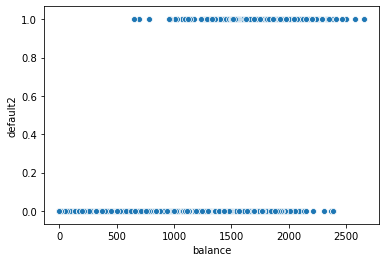

In [9]:
sns.scatterplot(df['balance'], df['default2'])

In [10]:
## Ensuring the sklearn is without regularizer. So it can match results from grad descent
# for c in [1e1, 1e3, 1e5, 1e10, 1e15]:
model_sk = skl_lm.LogisticRegression(fit_intercept = True, C = 1e3)
X = df[['balance']].values
model_sk.fit(X, y)
pred = model_sk.predict(X)

# All varied regularizer gave same coeff values, hence choose one value. Regularizer is used because we are scikit learn default uses regularizer, hence we wont be able match coeff btw gd & scikit learn.
# Hence, regularizer is nullified using "C" value 

In [11]:
def sigmoid(val):
    return 1/(1 + np.exp(-val))
alpha = 0.1
n = y.shape[0]
X_logit = sm.add_constant(df['balance'])
theta = np.zeros((X_logit.shape[1],1))
cost = []
iterations = 10000
for i in range(iterations):
    output = np.dot(X_logit, theta)
    predictions = sigmoid(output)
    grad = np.dot(X_logit.T, (y - predictions))
    theta = theta + (2*alpha/n)*grad
    # cost.append(-np.dot(y.T, np.log(predictions)) - np.dot((1- y).T, np.log(1 - predictions)))

In [12]:
print(model_sk.intercept_, model_sk.coef_)
print(theta)
pred_gd = sigmoid(np.dot(X_logit, theta))
pred_gd_binary = np.where(pred_gd > 0.5, 1, 0)
print(confusion_matrix(pred, y))
print(confusion_matrix(pred_gd_binary, y))

[-10.65132867] [[0.00549892]]
[[ -65.54200403]
 [-146.98360366]]
[[9625  233]
 [  42  100]]
[[9667  333]
 [   0    0]]


## Case 2 : iris dataset
### Observation : coeff values btw sklearn and gd did not match. But the confusion matrix matches. Probably indicating multiple coeff values for minimal cost. Or multiple separation hyperplane available for the dataset

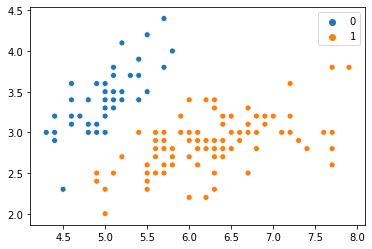

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data[:, :2]
y = (iris.target != 0) * 1
sns.scatterplot(x = x[:,0], y = x[:,1], hue = y)

In [14]:
model_sk = skl_lm.LogisticRegression(fit_intercept = True, C = .5e1)
model_sk.fit(x, y)
pred = model_sk.predict(x)
# print(c)

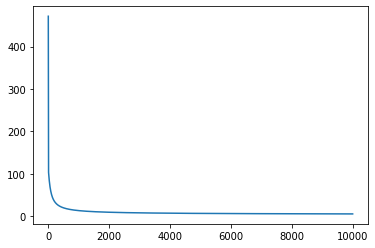

In [15]:
def sigmoid(val):
    return 1/(1 + np.exp(-val))
alpha = 0.05
n = y.shape[0]
X_logit = sm.add_constant(x)
theta = np.ones((X_logit.shape[1],1))
cost = []
iterations = 10000
y = y.reshape(-1, 1)
for i in range(iterations):
    output = np.dot(X_logit, theta)
    predictions = sigmoid(output)
    grad = np.dot(X_logit.T, (y - predictions))
    theta = theta + (2*alpha/n)*grad
    cost.append(-np.dot(y.T, np.log(predictions)) - np.dot((1- y).T, np.log(1 - predictions)))
plt.plot(np.arange(iterations), np.array(cost).reshape(-1,1))

pred_gd = sigmoid(np.dot(X_logit, theta))
pred_gd_binary = np.where(pred_gd > 0.5, 1, 0)

In [16]:
print(model_sk.intercept_, model_sk.coef_)
print(theta.T)
print(confusion_matrix(pred, y))
print(confusion_matrix(pred_gd_binary, y))

[-12.18502274] [[ 5.33522712 -5.29617515]]
[[-2.42355094  5.80778841 -9.31079015]]
[[ 50   0]
 [  0 100]]
[[ 49   0]
 [  1 100]]


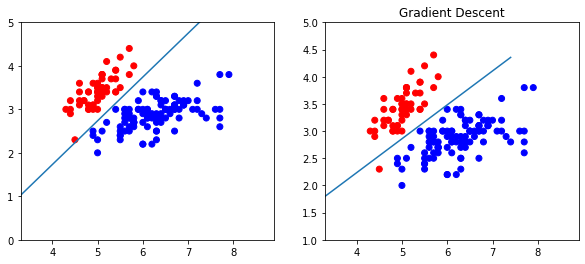

In [17]:
# Plotting the decision boundary
fig = plt.figure(figsize=(10,4))
plt.title("Scikit Learn")
plt.subplot(121)
x_values = [np.min(x[:, 1]-2), np.max(x[:, 1])+3]
y_values = np.dot((-1./model_sk.coef_[0][1]), (np.dot(model_sk.coef_[0][0],x_values) + model_sk.intercept_))
colors=['red' if l==0 else 'blue' for l in y]
plt.scatter(x[:, 0], x[:, 1], label='Logistics regression', color=colors)
plt.plot(x_values, y_values, label='Decision Boundary')
plt.xlim(x[:,:1].min()-1, x[:,:1].max()+1)
plt.ylim(0,5)

plt.subplot(122)
plt.title("Gradient Descent")
x_values = [np.min(x[:, 1]-2), np.max(x[:, 1])+3]
y_values = np.dot((-1./theta[2][0]), (np.dot(theta[1][0],x_values) + theta[0][0]))
colors=['red' if l==0 else 'blue' for l in y]
plt.scatter(x[:, 0], x[:, 1], label='Logistics regression', color=colors)
plt.plot(x_values, y_values, label='Decision Boundary')
plt.xlim(x[:,:1].min()-1, x[:,:1].max()+1)
plt.ylim(1,5)
plt.show()

In [18]:
# colors = [int(i % 23) for i in y]
# xx, yy = np.mgrid[3:10:.01, 1:6:.01]
# grid = np.c_[xx.ravel(), yy.ravel()]
# probs = model_sk.predict_proba(grid)[:, 1].reshape(xx.shape)
# f, ax = plt.subplots(figsize=(8, 6))
# contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])
# ax.scatter(x[:,0], x[:, 1], c = colors)

# f, ax = plt.subplots(figsize=(8, 6))
# pred_gd = sigmoid(np.dot(grid, theta[1:])).reshape(xx.shape)
# contour = ax.contourf(xx, yy, pred_gd, 25, cmap="RdBu",
#                       vmin=0, vmax=1)
# ax_c = f.colorbar(contour)
# ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])
# ax.scatter(x[:,0], x[:, 1], c = colors)

## Multiple Linear Regression

In [19]:
model_sk = skl_lm.LogisticRegression()
X = df[['balance', 'income', 'student2']].values
y = df['default2']
model_sk.fit(X, y)
pred = model_sk.predict(X)
print(model_sk.intercept_, model_sk.coef_)
confusion_matrix(pred, y)

[-2.9508496] [[ 4.08201022e-03 -1.33893466e-04 -3.89009045e+00]]


array([[9609,  271],
       [  58,   62]], dtype=int64)

In [20]:
X_logit = sm.add_constant(df[['balance', 'income', 'student2']]).values
model3 = sm.Logit(y, X_logit).fit()
model3_pred = model3.predict(X_logit)
model3_pred_list = [1 if i > 0.5 else 0 for i in model3_pred]
print(confusion_matrix(model3_pred_list, y))
model3.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
[[9627  228]
 [  40  105]]


<class 'statsmodels.iolib.table.SimpleTable'>

In [21]:
print(classification_report(y, model3_pred_list, target_names=['No', 'Yes']))

precision    recall  f1-score   support

          No       0.98      1.00      0.99      9667
         Yes       0.72      0.32      0.44       333

    accuracy                           0.97     10000
   macro avg       0.85      0.66      0.71     10000
weighted avg       0.97      0.97      0.97     10000



## Using LDA

In [22]:
lda = LinearDiscriminantAnalysis(solver = 'svd')
model_lda = lda.fit(X_logit, y)
pred = model_lda.predict(X_logit)
confusion_matrix(pred, y)
print(classification_report(y, pred, target_names=['No', 'Yes']))

precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000

